In [ ]:
!unzip /content/archive.zip 

In [26]:
import os
import random

import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [7]:
datasetDir = '/content/Micro_Expressions'
classes = os.listdir(datasetDir + '/train')
print('Expression Labels : ' ,classes)

Expression Labels :  ['anger', 'happiness', 'neutral', 'sadness', 'disgust', 'fear', 'surprise']


In [8]:
tfms = transforms.Compose([
                           transforms.RandomCrop(80, padding = 15, padding_mode = 'reflect'),
                           transforms.RandomHorizontalFlip(p = 0.5),
                           transforms.ToTensor()
                           ])

dataset1 = ImageFolder(datasetDir + '/train', tfms)
dataset2 = ImageFolder(datasetDir + '/train', transform = ToTensor())

dataset = dataset1 + dataset2
dataset.classes = ['anger', 'disgust', 'fear','happiness','neutral','sadness','surprise']

In [9]:
def image_show(image, label):
  print(f'Label : {dataset.classes[label]}')
  plt.imshow(image.permute(1, 2, 0)) # RGB channel is last in matplotlib and first in pytorch

Label : anger


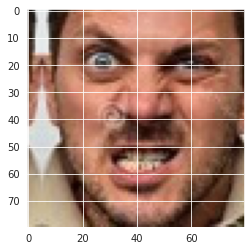

In [10]:
image_show(*dataset[786])

Label : anger


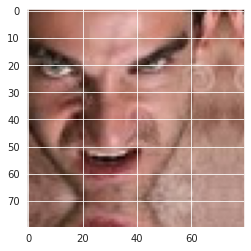

In [11]:
image_show(*dataset[100])

In [12]:
def seed_everything(seed = 786):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_everything()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
train_dataset, val_dataset = random_split(dataset, [len(dataset) - 2000, 2000])
print(f'Length of Training set : {len(train_dataset)}')
print(f'Length of Validation set : {len(val_dataset)}')

Length of Training set : 11876
Length of Validation set : 2000


In [15]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True, num_workers =  2, pin_memory = True)

In [16]:
from torchvision.utils import make_grid

def show_batch(data_loader):
  for images, labels in data_loader:
    fig, ax = plt.subplots(figsize = (16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 20).permute(1,2,0))
    break

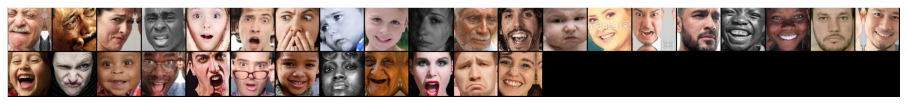

In [17]:
show_batch(train_loader)

In [18]:
for image, label in train_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([32, 3, 80, 80])
torch.Size([32])


In [19]:
net = torchvision.models.resnet18(pretrained=True)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
from torchsummary import summary
summary(net, (3, 80, 80 ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           9,408
       BatchNorm2d-2           [-1, 64, 40, 40]             128
              ReLU-3           [-1, 64, 40, 40]               0
         MaxPool2d-4           [-1, 64, 20, 20]               0
            Conv2d-5           [-1, 64, 20, 20]          36,864
       BatchNorm2d-6           [-1, 64, 20, 20]             128
              ReLU-7           [-1, 64, 20, 20]               0
            Conv2d-8           [-1, 64, 20, 20]          36,864
       BatchNorm2d-9           [-1, 64, 20, 20]             128
             ReLU-10           [-1, 64, 20, 20]               0
       BasicBlock-11           [-1, 64, 20, 20]               0
           Conv2d-12           [-1, 64, 20, 20]          36,864
      BatchNorm2d-13           [-1, 64, 20, 20]             128
             ReLU-14           [-1, 64,

In [21]:
len(dataset.classes)

7

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.0001)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(dataset.classes))
net.fc = net.fc.to(device)

In [23]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in tqdm(enumerate(train_loader)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in tqdm((val_loader)):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



2it [00:00,  5.59it/s]

Epoch [1/5], Step [0/372], Loss: 2.0126


22it [00:02, 11.67it/s]

Epoch [1/5], Step [20/372], Loss: 1.3972


42it [00:03, 11.89it/s]

Epoch [1/5], Step [40/372], Loss: 1.2263


62it [00:05, 12.07it/s]

Epoch [1/5], Step [60/372], Loss: 1.1159


82it [00:07, 11.93it/s]

Epoch [1/5], Step [80/372], Loss: 1.0939


102it [00:08, 12.04it/s]

Epoch [1/5], Step [100/372], Loss: 0.8419


122it [00:10, 11.87it/s]

Epoch [1/5], Step [120/372], Loss: 0.6537


142it [00:12, 12.16it/s]

Epoch [1/5], Step [140/372], Loss: 0.7990


162it [00:13, 12.07it/s]

Epoch [1/5], Step [160/372], Loss: 0.7853


182it [00:15, 12.17it/s]

Epoch [1/5], Step [180/372], Loss: 0.7331


202it [00:17, 12.02it/s]

Epoch [1/5], Step [200/372], Loss: 0.6273


222it [00:18, 12.10it/s]

Epoch [1/5], Step [220/372], Loss: 0.7681


242it [00:20, 11.96it/s]

Epoch [1/5], Step [240/372], Loss: 0.9459


262it [00:22, 12.04it/s]

Epoch [1/5], Step [260/372], Loss: 1.2109


282it [00:23, 12.13it/s]

Epoch [1/5], Step [280/372], Loss: 0.6569


302it [00:25, 12.15it/s]

Epoch [1/5], Step [300/372], Loss: 0.4523


322it [00:27, 12.01it/s]

Epoch [1/5], Step [320/372], Loss: 0.6324


342it [00:28, 10.43it/s]

Epoch [1/5], Step [340/372], Loss: 0.7478


361it [00:30,  9.25it/s]

Epoch [1/5], Step [360/372], Loss: 0.6952


372it [00:32, 11.59it/s]



train-loss: 0.9230, train-acc: 67.6827


100%|██████████| 63/63 [00:03<00:00, 18.95it/s]


validation loss: 0.6393, validation acc: 77.1000

Improvement-Detected, save-model
Epoch 2



3it [00:00,  8.45it/s]

Epoch [2/5], Step [0/372], Loss: 0.5815


21it [00:02, 11.25it/s]

Epoch [2/5], Step [20/372], Loss: 0.5110


43it [00:04, 10.07it/s]

Epoch [2/5], Step [40/372], Loss: 0.2944


63it [00:05, 11.94it/s]

Epoch [2/5], Step [60/372], Loss: 0.2810


83it [00:07, 11.96it/s]

Epoch [2/5], Step [80/372], Loss: 0.4507


103it [00:09, 11.92it/s]

Epoch [2/5], Step [100/372], Loss: 0.6147


123it [00:10, 12.07it/s]

Epoch [2/5], Step [120/372], Loss: 0.4574


143it [00:12, 12.15it/s]

Epoch [2/5], Step [140/372], Loss: 0.4202


163it [00:14, 11.91it/s]

Epoch [2/5], Step [160/372], Loss: 0.3921


183it [00:15, 12.08it/s]

Epoch [2/5], Step [180/372], Loss: 0.3013


203it [00:17, 12.20it/s]

Epoch [2/5], Step [200/372], Loss: 0.2770


223it [00:19, 12.18it/s]

Epoch [2/5], Step [220/372], Loss: 0.6207


243it [00:20, 12.22it/s]

Epoch [2/5], Step [240/372], Loss: 0.3234


263it [00:22, 12.17it/s]

Epoch [2/5], Step [260/372], Loss: 0.5581


283it [00:24, 12.24it/s]

Epoch [2/5], Step [280/372], Loss: 0.3640


303it [00:25, 12.05it/s]

Epoch [2/5], Step [300/372], Loss: 0.4186


323it [00:27, 12.20it/s]

Epoch [2/5], Step [320/372], Loss: 0.6911


343it [00:29, 12.14it/s]

Epoch [2/5], Step [340/372], Loss: 0.3553


363it [00:30, 11.98it/s]

Epoch [2/5], Step [360/372], Loss: 0.4413


372it [00:31, 11.81it/s]



train-loss: 0.7094, train-acc: 83.3951


100%|██████████| 63/63 [00:02<00:00, 28.13it/s]


validation loss: 0.5852, validation acc: 82.2500

Improvement-Detected, save-model
Epoch 3



3it [00:00,  9.16it/s]

Epoch [3/5], Step [0/372], Loss: 0.3592


23it [00:02, 11.88it/s]

Epoch [3/5], Step [20/372], Loss: 0.2517


43it [00:03, 12.10it/s]

Epoch [3/5], Step [40/372], Loss: 0.3438


63it [00:05, 11.93it/s]

Epoch [3/5], Step [60/372], Loss: 0.6674


83it [00:06, 12.13it/s]

Epoch [3/5], Step [80/372], Loss: 0.5375


103it [00:08, 12.02it/s]

Epoch [3/5], Step [100/372], Loss: 0.5091


123it [00:10, 12.06it/s]

Epoch [3/5], Step [120/372], Loss: 0.3355


143it [00:11, 11.87it/s]

Epoch [3/5], Step [140/372], Loss: 0.2579


163it [00:13, 12.08it/s]

Epoch [3/5], Step [160/372], Loss: 0.3166


183it [00:15, 11.95it/s]

Epoch [3/5], Step [180/372], Loss: 0.2636


203it [00:16, 12.04it/s]

Epoch [3/5], Step [200/372], Loss: 0.2218


223it [00:18, 12.17it/s]

Epoch [3/5], Step [220/372], Loss: 0.2560


243it [00:20, 11.88it/s]

Epoch [3/5], Step [240/372], Loss: 0.4618


263it [00:21, 11.91it/s]

Epoch [3/5], Step [260/372], Loss: 0.4501


283it [00:23, 12.03it/s]

Epoch [3/5], Step [280/372], Loss: 0.2069


303it [00:25, 11.94it/s]

Epoch [3/5], Step [300/372], Loss: 0.2966


323it [00:26, 11.94it/s]

Epoch [3/5], Step [320/372], Loss: 0.4452


343it [00:28, 12.10it/s]

Epoch [3/5], Step [340/372], Loss: 0.4254


363it [00:30, 12.07it/s]

Epoch [3/5], Step [360/372], Loss: 0.8822


372it [00:31, 11.98it/s]



train-loss: 0.5929, train-acc: 88.3883


100%|██████████| 63/63 [00:02<00:00, 29.00it/s]

validation loss: 0.5974, validation acc: 80.6000

Epoch 4




3it [00:00,  9.45it/s]

Epoch [4/5], Step [0/372], Loss: 0.3163


23it [00:02, 11.84it/s]

Epoch [4/5], Step [20/372], Loss: 0.2270


43it [00:03, 11.82it/s]

Epoch [4/5], Step [40/372], Loss: 0.3753


63it [00:05, 11.90it/s]

Epoch [4/5], Step [60/372], Loss: 0.0970


83it [00:07, 12.18it/s]

Epoch [4/5], Step [80/372], Loss: 0.2131


103it [00:08, 11.85it/s]

Epoch [4/5], Step [100/372], Loss: 0.4047


123it [00:10, 11.94it/s]

Epoch [4/5], Step [120/372], Loss: 0.3846


143it [00:12, 12.04it/s]

Epoch [4/5], Step [140/372], Loss: 0.6001


163it [00:13, 12.19it/s]

Epoch [4/5], Step [160/372], Loss: 0.3637


183it [00:15, 12.13it/s]

Epoch [4/5], Step [180/372], Loss: 0.2399


203it [00:17, 11.64it/s]

Epoch [4/5], Step [200/372], Loss: 0.1654


223it [00:18, 12.18it/s]

Epoch [4/5], Step [220/372], Loss: 0.2856


243it [00:20, 11.97it/s]

Epoch [4/5], Step [240/372], Loss: 0.5490


263it [00:21, 12.13it/s]

Epoch [4/5], Step [260/372], Loss: 0.4739


283it [00:23, 12.18it/s]

Epoch [4/5], Step [280/372], Loss: 0.3756


303it [00:25, 12.22it/s]

Epoch [4/5], Step [300/372], Loss: 0.2258


323it [00:26, 12.03it/s]

Epoch [4/5], Step [320/372], Loss: 0.1102


343it [00:28, 12.06it/s]

Epoch [4/5], Step [340/372], Loss: 0.2378


363it [00:30, 12.09it/s]

Epoch [4/5], Step [360/372], Loss: 0.0799


372it [00:31, 11.98it/s]



train-loss: 0.5219, train-acc: 90.1566


100%|██████████| 63/63 [00:02<00:00, 28.07it/s]


validation loss: 0.5600, validation acc: 85.3500

Improvement-Detected, save-model
Epoch 5



3it [00:00,  8.88it/s]

Epoch [5/5], Step [0/372], Loss: 0.1511


21it [00:01, 10.16it/s]

Epoch [5/5], Step [20/372], Loss: 0.1481


43it [00:03, 11.67it/s]

Epoch [5/5], Step [40/372], Loss: 0.1589


63it [00:05, 11.89it/s]

Epoch [5/5], Step [60/372], Loss: 0.2017


83it [00:07, 12.01it/s]

Epoch [5/5], Step [80/372], Loss: 0.1389


103it [00:08, 12.22it/s]

Epoch [5/5], Step [100/372], Loss: 0.1040


123it [00:10, 12.08it/s]

Epoch [5/5], Step [120/372], Loss: 0.1932


143it [00:12, 12.18it/s]

Epoch [5/5], Step [140/372], Loss: 0.2049


163it [00:13, 12.01it/s]

Epoch [5/5], Step [160/372], Loss: 0.2179


183it [00:15, 12.10it/s]

Epoch [5/5], Step [180/372], Loss: 0.1235


203it [00:17, 12.03it/s]

Epoch [5/5], Step [200/372], Loss: 0.1265


223it [00:18, 12.06it/s]

Epoch [5/5], Step [220/372], Loss: 0.2094


242it [00:20,  9.51it/s]

Epoch [5/5], Step [240/372], Loss: 0.1230


263it [00:22, 11.79it/s]

Epoch [5/5], Step [260/372], Loss: 0.4084


283it [00:24, 11.89it/s]

Epoch [5/5], Step [280/372], Loss: 0.1562


303it [00:26, 11.83it/s]

Epoch [5/5], Step [300/372], Loss: 0.1931


323it [00:27, 12.06it/s]

Epoch [5/5], Step [320/372], Loss: 0.2289


343it [00:29, 11.93it/s]

Epoch [5/5], Step [340/372], Loss: 0.1528


363it [00:31, 11.95it/s]

Epoch [5/5], Step [360/372], Loss: 0.4369


372it [00:31, 11.70it/s]



train-loss: 0.4683, train-acc: 91.7060


100%|██████████| 63/63 [00:02<00:00, 28.56it/s]

validation loss: 0.5427, validation acc: 85.4500



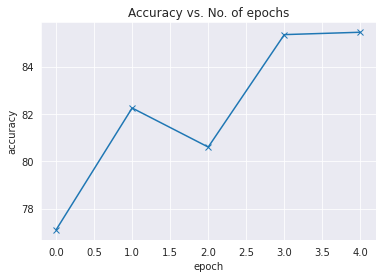

In [24]:
def plot_accuracies():
    accuracies = val_acc
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies()

In [25]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 85.8 %


In [27]:
clas_report = classification_report(lbllist.numpy(), predlist.numpy())
print(clas_report)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       372
           1       0.77      0.76      0.76       178
           2       0.75      0.76      0.76       119
           3       0.97      0.90      0.94       535
           4       0.72      0.90      0.80       153
           5       0.83      0.85      0.84       369
           6       0.87      0.88      0.88       274

    accuracy                           0.86      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.86      0.86      0.86      2000



In [28]:
matrix = confusion_matrix(lbllist.numpy(), predlist.numpy())
print(matrix)

[[312  19   6   1  15  14   5]
 [ 18 135   3   3   6  12   1]
 [  2   4  91   1   0   6  15]
 [  3   6   0 483   8  21  14]
 [  5   2   0   0 138   8   0]
 [ 12   9   3   4  24 315   2]
 [  3   1  18   6   2   2 242]]


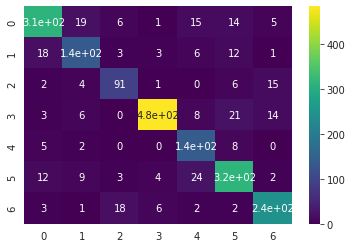

In [30]:
import seaborn as snNew
import pandas as pdNew
import matplotlib.pyplot as pltNew

DetaFrame_cm = pdNew.DataFrame(matrix, range(7), range(7))
snNew.heatmap(DetaFrame_cm, annot=True, cmap = 'viridis')
pltNew.show()

In [43]:
def predict_image(image, model):
    image = image.unsqueeze(0).to(device)
    output = net(image)
    _, preds  = torch.max(output, dim=1)
    return dataset.classes[preds[0].item()]

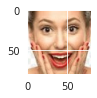

Label: surprise , Predicted: happiness


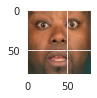

Label: surprise , Predicted: happiness


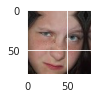

Label: disgust , Predicted: happiness


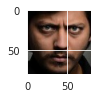

Label: anger , Predicted: happiness


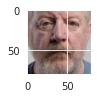

Label: neutral , Predicted: happiness


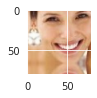

Label: happiness , Predicted: happiness


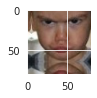

Label: anger , Predicted: happiness


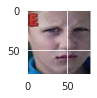

Label: anger , Predicted: happiness


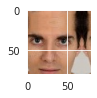

Label: neutral , Predicted: happiness


In [44]:
indexes = [np.random.randint(0, len(dataset)) for _ in range(9)]
i = 0
for index in indexes:
  image, label = dataset[index]
  plt.subplot(3, 3, i + 1)
  plt.imshow(image.permute(1,2,0))
  plt.show()
  i+=1
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(image, net))